In [1]:
library(Seurat)
library(patchwork)
library(dplyr)
library(Matrix)
library(biomaRt)
library(ggplot2)
library(ggpubr)

Attaching SeuratObject


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
setwd('/lustre1/project/stg_00041/Irene/10X_NAIVE_TSC_2021/nonaggr_noMEFs_mouse_human_analysis/')

Load data sets

In [ ]:
matNAIVE <- read.csv("NAIVE_DMSO_38_countMtx_Irene_2021.csv",row.names =1)
matNAIVEPRC2i <- read.csv("NAIVE_PRC2i_38_countMtx_Irene_2021.csv",row.names =1)

In [ ]:
seurat_object_NAIVE <- CreateSeuratObject(
  counts = matNAIVE,
  project = "naive_TSC_PRC2i_Irene_VP", 
  min.cells = 0,
  min.features = 0)

seurat_object_NAIVE_PRC2i <- CreateSeuratObject(
  counts = matNAIVEPRC2i,
  project = "naive_TSC_PRC2i_Irene_VP", 
  min.cells = 0,
  min.features = 0)



In [33]:
seurat_object_NAIVE
seurat_object_NAIVE_PRC2i


An object of class Seurat 
24370 features across 3894 samples within 1 assay 
Active assay: RNA (24370 features, 0 variable features)

An object of class Seurat 
24370 features across 4149 samples within 1 assay 
Active assay: RNA (24370 features, 0 variable features)

check that the features (genes) and samples (cells) still have the correct number as before in our count matrix

In [34]:
head(seurat_object_NAIVE@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCAAGAAACTAC.1,naive_TSC_PRC2i_Irene_VP,404,319
AAACCCACACATTACG.1,naive_TSC_PRC2i_Irene_VP,459,334
AAACCCACAGGCGTTC.1,naive_TSC_PRC2i_Irene_VP,13538,3997
AAACCCAGTATGAGCG.1,naive_TSC_PRC2i_Irene_VP,23685,5289
AAACGAAAGATAGTGT.1,naive_TSC_PRC2i_Irene_VP,322,239


Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. A few QC metrics commonly used by the community include

The number of unique genes detected in each cell.
Low-quality cells or empty droplets will often have very few genes
Cell doublets or multiplets may exhibit an aberrantly high gene count
Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)
The percentage of reads that map to the mitochondrial genome
Low-quality / dying cells often exhibit extensive mitochondrial contamination
We calculate mitochondrial QC metrics with the PercentageFeatureSet() function, which calculates the percentage of counts originating from a set of features
We use the set of all genes starting with MT- as a set of mitochondrial genes

let's check human and mouse mitochondrial genes (MT for human and mt for mouse)

In [35]:
MT.geneNAIVE <- grep(pattern = "^MT-", x = rownames(matNAIVE), value = TRUE) 
MT.geneNAIVEPRC2i <- grep(pattern = "^MT-", x = rownames(matNAIVEPRC2i), value = TRUE) 


In [36]:
head(MT.geneNAIVE)

[1] "MT-ND6" "MT-CO2" "MT-CYB" "MT-ND2" "MT-ND5" "MT-CO1"

In [37]:
seurat_object_NAIVE[["percent.MT"]] <- PercentageFeatureSet(seurat_object_NAIVE, pattern = "^MT[-]")
seurat_object_NAIVE_PRC2i[["percent.MT"]] <- PercentageFeatureSet(seurat_object_NAIVE_PRC2i, pattern = "^MT[-]")


In [38]:
head(seurat_object_NAIVE@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.MT
,<fct>,<dbl>,<int>,<dbl>
AAACCCAAGAAACTAC.1,naive_TSC_PRC2i_Irene_VP,404,319,7.178218
AAACCCACACATTACG.1,naive_TSC_PRC2i_Irene_VP,459,334,10.893246
AAACCCACAGGCGTTC.1,naive_TSC_PRC2i_Irene_VP,13538,3997,10.082730
AAACCCAGTATGAGCG.1,naive_TSC_PRC2i_Irene_VP,23685,5289,12.037154
AAACGAAAGATAGTGT.1,naive_TSC_PRC2i_Irene_VP,322,239,10.869565
AAACGAAAGGCCTGAA.1,naive_TSC_PRC2i_Irene_VP,19616,4812,5.082586


In [39]:
seurat_object_NAIVE_fil1 <- subset(seurat_object_NAIVE, 
                                       subset = percent.MT < 25 & nCount_RNA < 40000 & nCount_RNA > 3000 &  nFeature_RNA < 8000 & nFeature_RNA > 1500)

In [40]:
seurat_object_NAIVE_PRC2i_fil1 <- subset(seurat_object_NAIVE_PRC2i, 
                                       subset = percent.MT < 25 & nCount_RNA < 40000 & nCount_RNA > 3000 &  nFeature_RNA < 8000 & nFeature_RNA > 1500)

In [41]:
seurat_object_NAIVE_fil1
seurat_object_NAIVE_PRC2i_fil1


An object of class Seurat 
24370 features across 2903 samples within 1 assay 
Active assay: RNA (24370 features, 0 variable features)

An object of class Seurat 
24370 features across 3338 samples within 1 assay 
Active assay: RNA (24370 features, 0 variable features)

## Merge the 2 seurat objects into 1

merge merges the raw count matrices of two Seurat objects and creates a new Seurat object with the resulting combined raw count matrix. To easily tell which original object any particular cell came from, you can set the add.cell.ids parameter with an c(x, y) vector, which will prepend the given identifier to the beginning of each cell name.

In [42]:
seurat_object_naive <- merge(seurat_object_NAIVE_fil1, y = seurat_object_NAIVE_PRC2i_fil1, add.cell.ids = c("NAIVE", "NAIVEPRC2i"), project = "NAIVE_TSC_PRC2i_Irene_VP")
seurat_object_naive

An object of class Seurat 
24370 features across 6241 samples within 1 assay 
Active assay: RNA (24370 features, 0 variable features)

In [43]:
head(seurat_object_naive@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.MT
,<chr>,<dbl>,<int>,<dbl>
NAIVE_AAACCCACAGGCGTTC.1,naive_TSC_PRC2i_Irene_VP,13538,3997,10.082730
NAIVE_AAACCCAGTATGAGCG.1,naive_TSC_PRC2i_Irene_VP,23685,5289,12.037154
NAIVE_AAACGAAAGGCCTGAA.1,naive_TSC_PRC2i_Irene_VP,19616,4812,5.082586
NAIVE_AAACGAACACCAATTG.1,naive_TSC_PRC2i_Irene_VP,16231,4240,9.679009
NAIVE_AAACGCTAGGGCGAAG.1,naive_TSC_PRC2i_Irene_VP,10216,3348,10.512921
NAIVE_AAACGCTGTCAAGCCC.1,naive_TSC_PRC2i_Irene_VP,10190,3335,6.849853


## Normalize your count matrix

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in pbmc[["RNA"]]@data.

In [44]:
seurat_object <- NormalizeData(seurat_object_naive, normalization.method = "LogNormalize", scale.factor = 10000)

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others).
These will be used in downstream analysis, like PCA.

In [45]:
seurat_object <- FindVariableFeatures(seurat_object, selection.method = "vst", nfeatures = 2000)

In [46]:
dim(seurat_object@assays$RNA)
seurat_object@assays$RNA[1:5,1:5]

[1] 24370  6241

5 x 5 sparse Matrix of class "dgCMatrix"
         NAIVE_AAACCCACAGGCGTTC.1 NAIVE_AAACCCAGTATGAGCG.1
SCYL3                           .                .        
C1orf112                        .                0.3522107
FGR                             .                .        
CFH                             .                .        
STPG1                           .                .        
         NAIVE_AAACGAAAGGCCTGAA.1 NAIVE_AAACGAACACCAATTG.1
SCYL3                           .                        .
C1orf112                        .                        .
FGR                             .                        .
CFH                             .                        .
STPG1                           .                        .
         NAIVE_AAACGCTAGGGCGAAG.1
SCYL3                   .        
C1orf112                .        
FGR                     .        
CFH                     .        
STPG1                   0.6825193

In [47]:
top20 <- head(VariableFeatures(seurat_object), 20)

In [48]:
print(top20)

 [1] "H3Y1"      "VIM"       "TPRX1"     "MBD3L2B"   "FAM151A"   "SLC34A2"  
 [7] "MBD3L2"    "LEUTX"     "PRAMEF5"   "LINC01882" "PRAMEF12"  "CCBE1"    
[13] "NEAT1"     "CCNA1"     "MSANTD5"   "RFPL4B"    "LINC01220" "VCX3B"    
[19] "DHRS9"     "RNF222"   


## Scaling the data

Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. This might take long.

In [49]:
all.genes <- rownames(seurat_object)
seurat_object <- ScaleData(seurat_object, features = all.genes)

Centering and scaling data matrix



In [50]:
dim(seurat_object@assays$RNA)

[1] 24370  6241

Retrieve Sample IDs

In [53]:
barcode <- rownames(seurat_object@meta.data)

In [54]:
seurat_object_2 <- cbind(barcode,seurat_object@meta.data)

In [55]:
head(seurat_object_2)

,barcode,orig.ident,nCount_RNA,nFeature_RNA,percent.MT
,<chr>,<chr>,<dbl>,<int>,<dbl>
NAIVE_AAACCCACAGGCGTTC.1,NAIVE_AAACCCACAGGCGTTC.1,naive_TSC_PRC2i_Irene_VP,13538,3997,10.082730
NAIVE_AAACCCAGTATGAGCG.1,NAIVE_AAACCCAGTATGAGCG.1,naive_TSC_PRC2i_Irene_VP,23685,5289,12.037154
NAIVE_AAACGAAAGGCCTGAA.1,NAIVE_AAACGAAAGGCCTGAA.1,naive_TSC_PRC2i_Irene_VP,19616,4812,5.082586
NAIVE_AAACGAACACCAATTG.1,NAIVE_AAACGAACACCAATTG.1,naive_TSC_PRC2i_Irene_VP,16231,4240,9.679009
NAIVE_AAACGCTAGGGCGAAG.1,NAIVE_AAACGCTAGGGCGAAG.1,naive_TSC_PRC2i_Irene_VP,10216,3348,10.512921
NAIVE_AAACGCTGTCAAGCCC.1,NAIVE_AAACGCTGTCAAGCCC.1,naive_TSC_PRC2i_Irene_VP,10190,3335,6.849853


In [7]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
Warning message:
"Your system is mis-configured: '/etc/localtime' is not a symlink"
Warning message:
"It is strongly recommended to set envionment variable TZ to 'Europe/Brussels' (or equivalent)"
Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------ tidyverse 1.3.1 --

v tibble  3.1.2     v purrr   0.3.4
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts --------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x BiocGenerics::Position() masks ggplot2::Position(), base::Position()
x IRanges::collapse()      masks dplyr::collapse()
x Biobase::combine()   

In [57]:
seurat_object_3 <- separate(seurat_object_2, barcode, c("sample_ID", NA), sep = "_", remove = FALSE)

In [58]:
head(seurat_object_3)

,barcode,sample_ID,orig.ident,nCount_RNA,nFeature_RNA,percent.MT
,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
NAIVE_AAACCCACAGGCGTTC.1,NAIVE_AAACCCACAGGCGTTC.1,NAIVE,naive_TSC_PRC2i_Irene_VP,13538,3997,10.082730
NAIVE_AAACCCAGTATGAGCG.1,NAIVE_AAACCCAGTATGAGCG.1,NAIVE,naive_TSC_PRC2i_Irene_VP,23685,5289,12.037154
NAIVE_AAACGAAAGGCCTGAA.1,NAIVE_AAACGAAAGGCCTGAA.1,NAIVE,naive_TSC_PRC2i_Irene_VP,19616,4812,5.082586
NAIVE_AAACGAACACCAATTG.1,NAIVE_AAACGAACACCAATTG.1,NAIVE,naive_TSC_PRC2i_Irene_VP,16231,4240,9.679009
NAIVE_AAACGCTAGGGCGAAG.1,NAIVE_AAACGCTAGGGCGAAG.1,NAIVE,naive_TSC_PRC2i_Irene_VP,10216,3348,10.512921
NAIVE_AAACGCTGTCAAGCCC.1,NAIVE_AAACGCTGTCAAGCCC.1,NAIVE,naive_TSC_PRC2i_Irene_VP,10190,3335,6.849853


In [59]:
unique(seurat_object_3$sample_ID)

[1] "NAIVE"      "NAIVEPRC2i"

In [60]:
class(seurat_object_3)

[1] "data.frame"

In [61]:
sampleidentity <- seurat_object_3["sample_ID"]

In [62]:
head(sampleidentity)

,sample_ID
,<chr>
NAIVE_AAACCCACAGGCGTTC.1,NAIVE
NAIVE_AAACCCAGTATGAGCG.1,NAIVE
NAIVE_AAACGAAAGGCCTGAA.1,NAIVE
NAIVE_AAACGAACACCAATTG.1,NAIVE
NAIVE_AAACGCTAGGGCGAAG.1,NAIVE
NAIVE_AAACGCTGTCAAGCCC.1,NAIVE


In [63]:
sampleidentity$sample_ID <- as.character(sampleidentity$sample_ID)

In [64]:
class(sampleidentity$sample_ID)

[1] "character"

In [65]:
seurat_object_samples <- AddMetaData(
    object = seurat_object, 
    metadata = sampleidentity$sample_ID, 
    col.name = 'sample')

In [66]:
head(seurat_object_samples@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.MT,sample
,<chr>,<dbl>,<int>,<dbl>,<chr>
NAIVE_AAACCCACAGGCGTTC.1,naive_TSC_PRC2i_Irene_VP,13538,3997,10.082730,NAIVE
NAIVE_AAACCCAGTATGAGCG.1,naive_TSC_PRC2i_Irene_VP,23685,5289,12.037154,NAIVE
NAIVE_AAACGAAAGGCCTGAA.1,naive_TSC_PRC2i_Irene_VP,19616,4812,5.082586,NAIVE
NAIVE_AAACGAACACCAATTG.1,naive_TSC_PRC2i_Irene_VP,16231,4240,9.679009,NAIVE
NAIVE_AAACGCTAGGGCGAAG.1,naive_TSC_PRC2i_Irene_VP,10216,3348,10.512921,NAIVE
NAIVE_AAACGCTGTCAAGCCC.1,naive_TSC_PRC2i_Irene_VP,10190,3335,6.849853,NAIVE


In [67]:
seurat_object_samples

An object of class Seurat 
24370 features across 6241 samples within 1 assay 
Active assay: RNA (24370 features, 2000 variable features)
 1 dimensional reduction calculated: pca

In [71]:
head(Idents(seurat_object_samples), 5)

NAIVE_AAACCCACAGGCGTTC.1 NAIVE_AAACCCAGTATGAGCG.1 NAIVE_AAACGAAAGGCCTGAA.1 
naive_TSC_PRC2i_Irene_VP naive_TSC_PRC2i_Irene_VP naive_TSC_PRC2i_Irene_VP 
NAIVE_AAACGAACACCAATTG.1 NAIVE_AAACGCTAGGGCGAAG.1 
naive_TSC_PRC2i_Irene_VP naive_TSC_PRC2i_Irene_VP 
Levels: naive_TSC_PRC2i_Irene_VP

In [72]:
Idents(seurat_object_samples) <- "sample"

In [73]:
head(Idents(seurat_object_samples), 5)

NAIVE_AAACCCACAGGCGTTC.1 NAIVE_AAACCCAGTATGAGCG.1 NAIVE_AAACGAAAGGCCTGAA.1 
                   NAIVE                    NAIVE                    NAIVE 
NAIVE_AAACGAACACCAATTG.1 NAIVE_AAACGCTAGGGCGAAG.1 
                   NAIVE                    NAIVE 
Levels: NAIVE NAIVEPRC2i

Warning message:
"CombinePlots is being deprecated. Plots should now be combined using the patchwork system."


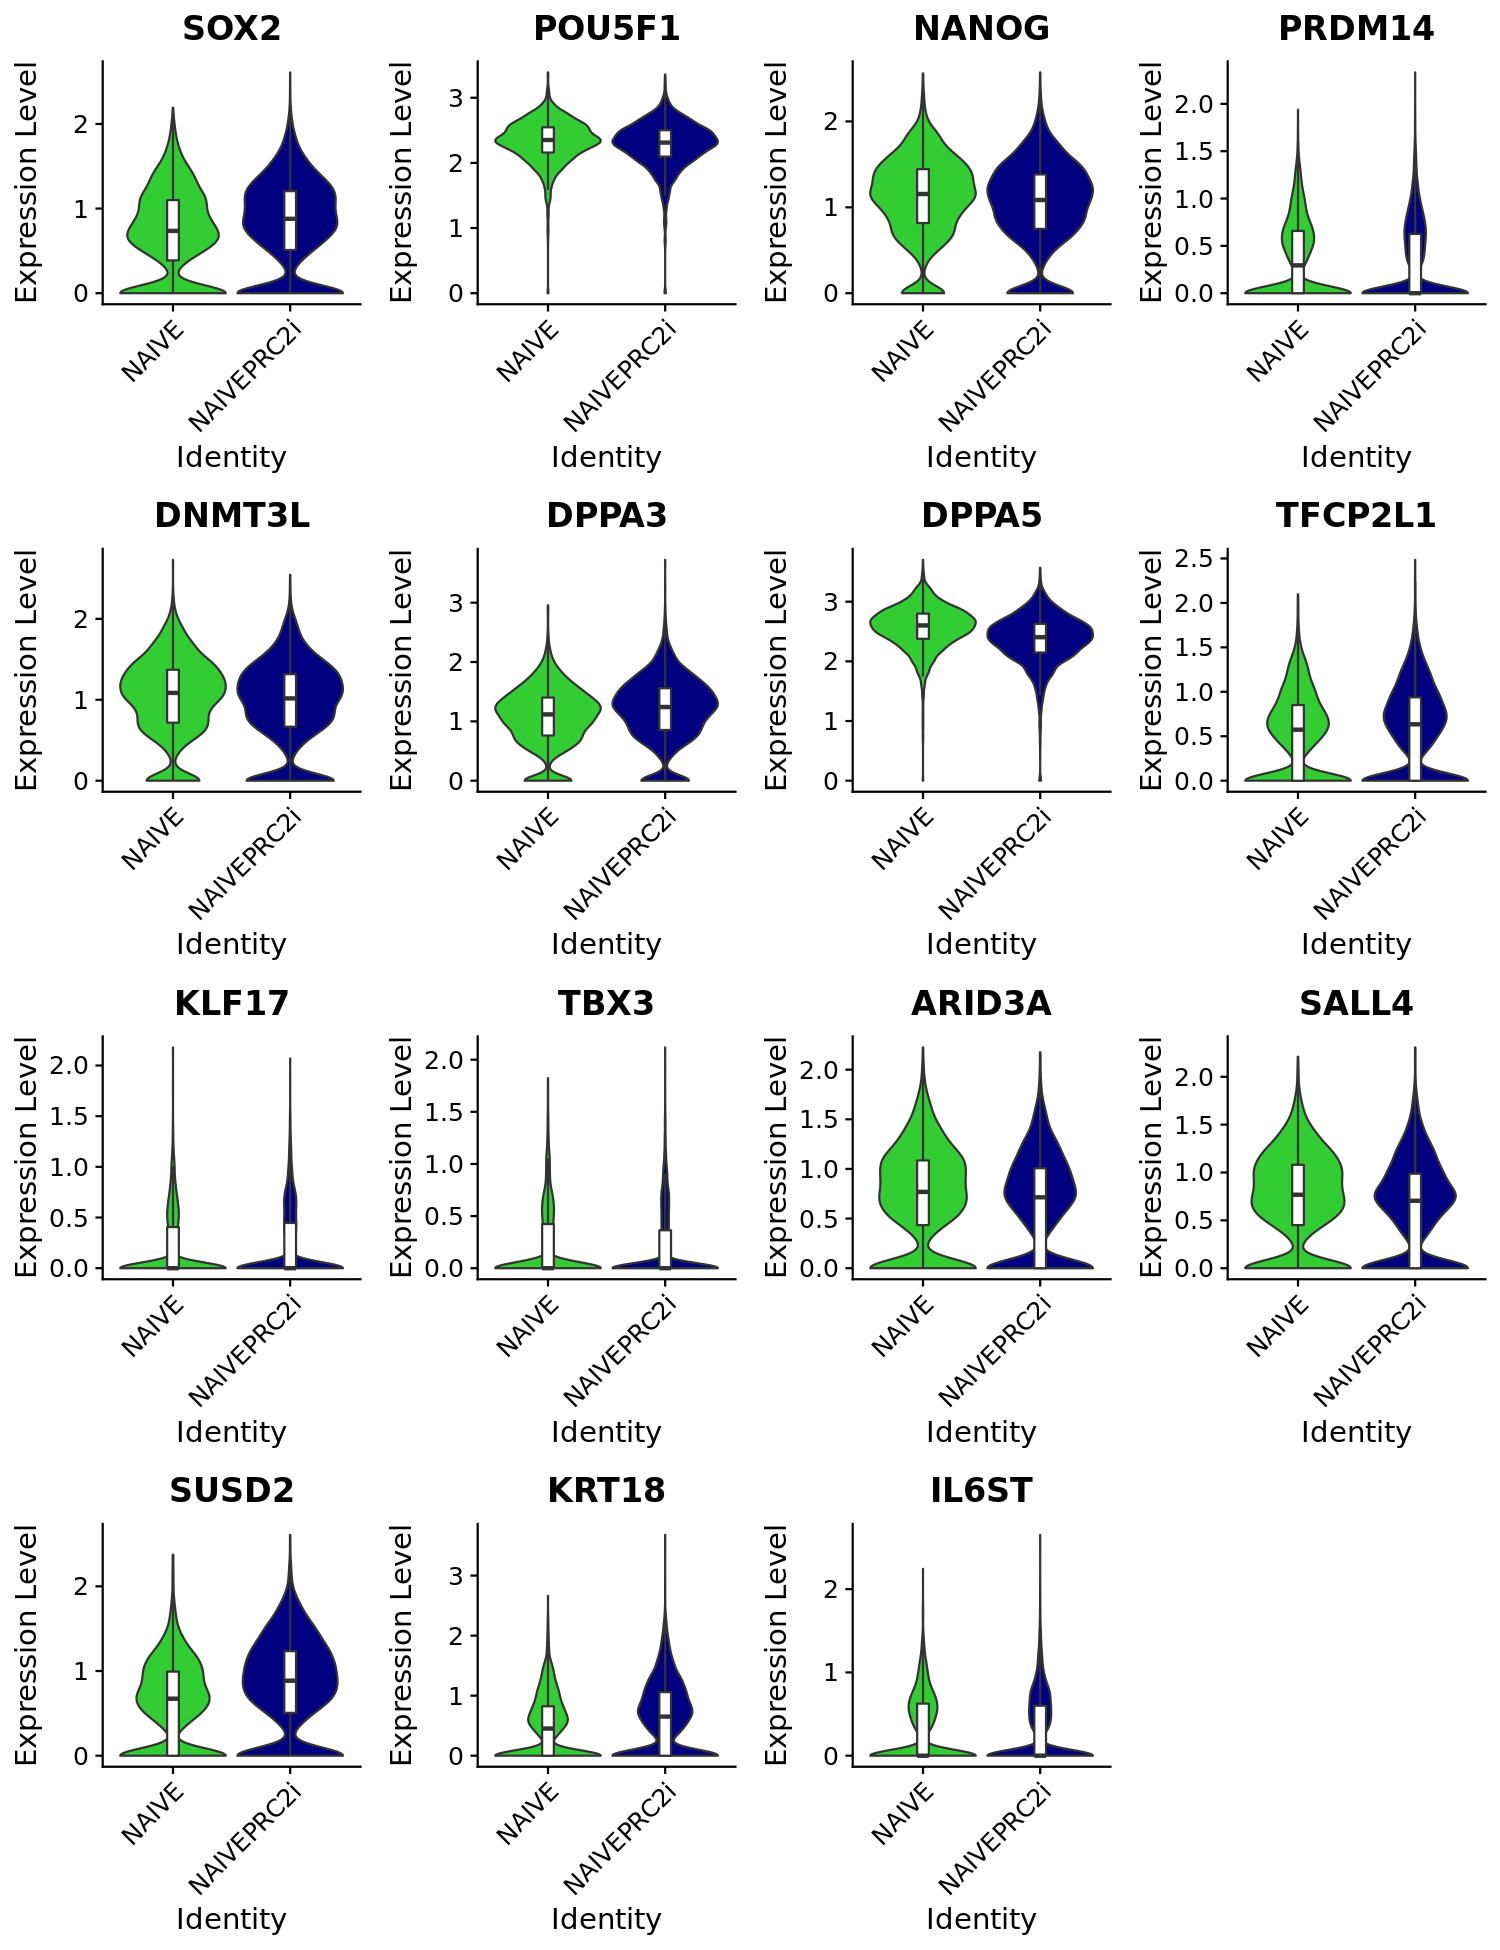

In [13]:
options(repr.plot.width = 10, repr.plot.height = 13, repr.plot.res = 150)
plots_violins <- VlnPlot(seurat_object_samples, 
        cols = c("limegreen", "navy"),
        #pt.size = 0.02,
        #same.y.lims = c(1,5),
        pt.size = 0,
        group.by = "sample",
        features = c("SOX2", "POU5F1", "NANOG", "PRDM14", "DNMT3L", "DPPA3", "DPPA5", "TFCP2L1", "KLF17","TBX3", 
                                                                          "ARID3A", "SALL4", "SUSD2", "KRT18","IL6ST"), 
        ncol = 6, 
        log = FALSE,
        combine = FALSE)


for(i in 1:length(plots_violins)) {
  plots_violins[[i]] <- plots_violins[[i]] + geom_boxplot(width=0.1, fill="white", outlier.shape = NA) + theme(legend.position = 'none')
}
                                                          
CombinePlots(plots_violins)

In [14]:
pdf(file="UMAP_naive_prc2i_markers_V3.pdf", width = 10, height = 13)

plots_violins <- VlnPlot(seurat_object_samples, 
        cols = c("limegreen", "navy"),
        #pt.size = 0.02,
        #same.y.lims = c(1,5),
        pt.size = 0,
        group.by = "sample",
        features = c("SOX2", "POU5F1", "NANOG", "PRDM14", "DNMT3L", "DPPA3", "DPPA5", "TFCP2L1", "KLF17","TBX3", 
                                                                          "ARID3A", "SALL4", "SUSD2", "KRT18","IL6ST"), 
        ncol = 6, 
        log = FALSE,
        combine = FALSE)


for(i in 1:length(plots_violins)) {
  plots_violins[[i]] <- plots_violins[[i]] + geom_boxplot(width=0.1, fill="white", outlier.shape = NA) + theme(legend.position = 'none')
}
                                                          
CombinePlots(plots_violins)
dev.off()

Warning message:
"CombinePlots is being deprecated. Plots should now be combined using the patchwork system."


png 
  2